In [1]:
#import pygmt
#import pyshtools as pysh
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import stripy
#from gprm.utils.raster import write_xyz_file
#import ptt.utils.call_system_command as call_system_command


def write_xyz_file(output_filename, output_data):
    """
    write data arrays to an xyz file
    :param filename: (string) name of output ascii file
    :param output_data: name of array containing data to be written
    """
    with open(output_filename, 'w') as output_file:
        for output_line in output_data:
            output_file.write(' '.join(str(item) for item in output_line) + '\n')
            


"""
    Copyright (C) 2017 The University of Sydney, Australia
    
    This program is free software; you can redistribute it and/or modify it under
    the terms of the GNU General Public License, version 2, as published by
    the Free Software Foundation.
    
    This program is distributed in the hope that it will be useful, but WITHOUT
    ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or
    FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License
    for more details.
    
    You should have received a copy of the GNU General Public License along
    with this program; if not, write to Free Software Foundation, Inc.,
    51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
"""

from __future__ import print_function

import subprocess
import sys


# Function to call a command on the system (based on 'subprocess' module).
#   Option to check return code of command and which return code to check (defaults to checking code 0 for success).
#   Option to raise error or return False on failure (raises by default).
#   Option to print an error message to stderr on failure (prints by default).
#   Option to pass a stdin string to the standard input of command (not passed by default).
#   Option to receive stdout/stderr strings from the standard output/error of command (not received by default).
#   Optionally pass advanced parameters to 'subprocess.Popen()' such as 'shell=True' (no advanced parameters passed by default).
#
# On success:
#    Returns (stdout, stderr) tuple of strings if 'return_stdout' and 'return_stderr' are True,
#    else returns stdout string if only 'return_stdout' is True,
#    else returns stderr string if only 'return_stderr' is True,
#    else returns True (if both 'return_stdout' and 'return_stderr' are False).
#
# On failure:
#    Raises an exception if 'raise_errors' is True,
#    else returns None (which can be tested as if it was 'False').
#
def call_system_command(
        args,  # Command and its arguments - either a single string or a sequence of arguments (see subprocess.Popen()).
        check_return_code=0,  # Check command's return code with this value (set to None to avoid checking).
        raise_errors=True,  # Whether to raise an exception when there's an error (terminates calling script unless caught).
        print_errors=True,  # Whether to print an error message to stderr when there's an error.
        stdin=None,  # Optional string to send to stdin of the command.
        return_stdout=False,  # Whether to capture, and return, stdout of the command,
        return_stderr=False,  # Whether to capture, and return, stderr of the command,
        **subprocess_options):  # Advanced options passed directly to subprocess.Popen().
    
    # Whether to send stdin to command.
    if stdin is not None:
        stdin_pipe = subprocess.PIPE
    else:
        stdin_pipe = None
    
    # Whether to receive stdout/stderr from command.
    if return_stdout:
        stdout_pipe = subprocess.PIPE
    else:
        stdout_pipe = None
    if return_stderr:
        stderr_pipe = subprocess.PIPE
    else:
        stderr_pipe = None
    
    # Execute command.
    try:
        command = subprocess.Popen(args, stdin=stdin_pipe, stdout=stdout_pipe, stderr=stderr_pipe, universal_newlines=True, **subprocess_options)
        stdout, stderr = command.communicate(stdin)
    except ValueError as e:
        if print_errors:
            print("System command called with invalid arguments: {0}".format(e), file=sys.stderr)
        if not raise_errors:
            return None
        raise
    except OSError as e:
        if print_errors:
            print("Unable to execute system command: {0} {1}".format(args, e), file=sys.stderr)
        if not raise_errors:
            return None
        raise
    
    # Check return code (if requested).
    if check_return_code is not None:
        command_return_code = command.poll()
        if command_return_code != check_return_code:
            if print_errors:
                print("System command failed: {0} return code: {1}".format(args, command_return_code), file=sys.stderr)
            if not raise_errors:
                return None
            
            # Raise same error that subprocess.check_call() does.
            raise subprocess.CalledProcessError(command_return_code, args, output=stdout)
    
    # Return (stdout, stderr) tuple if requested.
    if return_stdout and return_stderr:
        return stdout, stderr
    elif return_stdout:
        return stdout
    elif return_stderr:
        return stderr
    
    return True



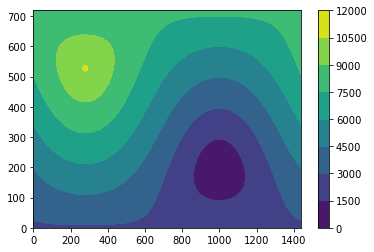

10669.445
10649.999095669398


In [2]:
crater_name = 'Hellas'

if crater_name=='Hellas':
    CraterDistance = xr.open_dataarray('DistanceToHellasCentre.nc')
    inner_limit = 500.
    outer_limit = 2000.
    
elif crater_name=='Argyre':
    CraterDistance = xr.open_dataarray('DistanceToArgyreCentre.nc')
    inner_limit = 500.
    outer_limit = 1800.
    
elif crater_name=='Isidis':
    CraterDistance = xr.open_dataarray('DistanceToIsidisCentre.nc')
    inner_limit = 500.
    outer_limit = 1500.
    
    
plt.contourf(CraterDistance.data)
plt.colorbar()
plt.show()

print(CraterDistance.data.max())
print(3390*np.pi)


lons,lats = np.meshgrid(CraterDistance.lon.data, CraterDistance.lat.data)


In [3]:
# generic function to interpolate nans, based on a raster where the 
# there is a mixture of nans and real numbers
# values are only interpolated at the nodes specified
# by 'ind_hole', then mapped back into the raster
def interpolate_hole(lons, lats, ramping, ind_hole, method='stripy'):

    if method=='stripy':
        ind = np.isnan(ramping.flatten())
        basis_X = lons.flatten()[~ind]
        basis_Y = lats.flatten()[~ind]
        basis_Z = ramping.flatten()[~ind]   

        target_X = lons.flatten()[ind_hole]
        target_Y = lats.flatten()[ind_hole]

        tri = stripy.sTriangulation(lons=np.radians(basis_X.flatten()), lats=np.radians(basis_Y.flatten()))

        ramp_interp = tri.interpolate(np.radians(target_X), np.radians(target_Y),
                                              zdata=basis_Z,
                                              order=1)[0]

        ramping[np.unravel_index(ind_hole.nonzero(), ramping.shape)] = ramp_interp
        
    elif method=='greenspline':
        
        desamp = 10
        ind = np.isnan(ramping[::desamp,::desamp].flatten())
        basis_X = lons[::desamp,::desamp].flatten()[~ind]
        basis_Y = lats[::desamp,::desamp].flatten()[~ind]
        basis_Z = ramping[::desamp,::desamp].flatten()[~ind]   

        target_X = lons.flatten()[ind_hole]
        target_Y = lats.flatten()[ind_hole]
        
        # Save to an ascii file
        np.savetxt('tmp.xyz', np.vstack((basis_X, 
                                         basis_Y, 
                                         basis_Z)).T, fmt='%1.12f')
                                        
        call_system_command(['gmt', 'greenspline', 'tmp.xyz', '-V', '-RDistanceTo{:s}Centre.nc'.format(crater_name), 
                             '-Sp', '-Z3', '-Gtmp.nc', '-Ttmpmask.nc'])
                                        
        ramp_interp = xr.open_dataarray('tmp.nc')

        plt.contourf(ramp_interp.data)
        plt.colorbar()
        plt.show()
        
        ramping[np.unravel_index(ind_hole.nonzero(), ramping.shape)] = ramp_interp.data.flatten()[ind_hole]
        ramp_interp.close()

    return ramping





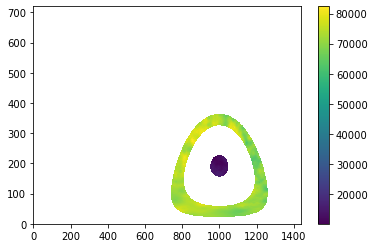

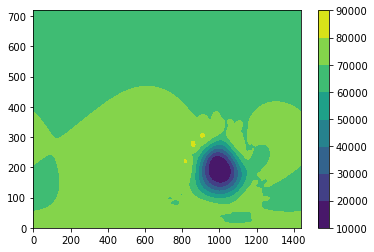

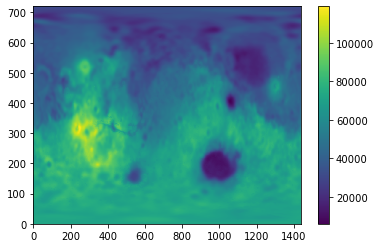

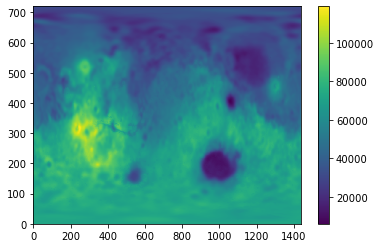

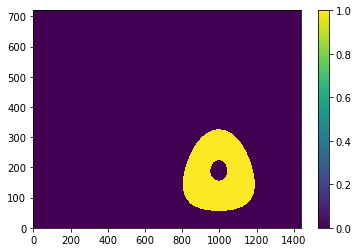

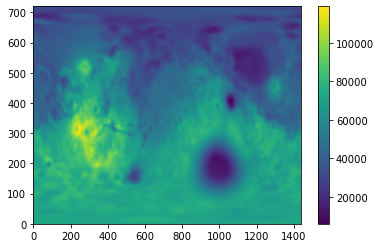

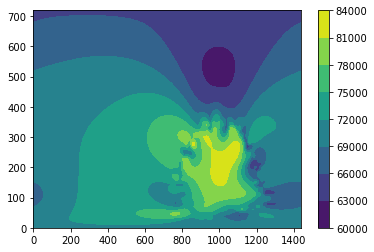

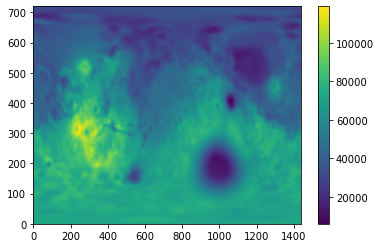

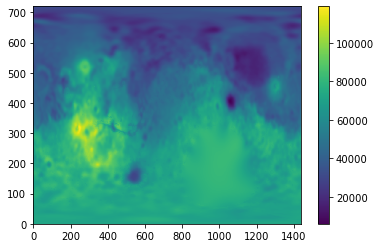

In [4]:
HM = np.loadtxt('grids/W19_l90.xyz')

sus = HM[:,2].reshape(720,1440)
sus = np.hstack((sus[:,720:],sus[:,:720]))

sus_in = sus.copy()
sus_orig = sus.copy()
sus_ramp = sus.copy()
sus_fill = sus.copy()



# smoothing case
sus[np.logical_and(CraterDistance.data<outer_limit,CraterDistance.data>inner_limit)] = np.nan

ind_hole = np.isnan(sus.flatten())
mskgrd = CraterDistance.copy()
mskgrd.data = np.logical_not(np.isnan(sus))
mskgrd.to_netcdf('tmpmask.nc')

sus[CraterDistance.data>outer_limit*1.25] = np.nan
#ind_outer_hole = np.isnan(sus.flatten())

plt.pcolormesh(sus)
plt.colorbar()
plt.show()

sus = interpolate_hole(lons, lats, sus, ind_hole, method='greenspline')

plt.pcolormesh(sus_ramp)
plt.colorbar()
plt.show()

sus_ramp[np.unravel_index(ind_hole.nonzero(), sus_ramp.shape)] = sus[np.unravel_index(ind_hole.nonzero(), sus.shape)]

plt.pcolormesh(sus_orig)
plt.colorbar()
plt.show()

plt.pcolormesh(ind_hole.reshape(sus_ramp.shape))
plt.colorbar()
plt.show()

plt.pcolormesh(sus_ramp)
plt.colorbar()
plt.show()

# filling case
sus = sus_orig.copy()
sus[CraterDistance.data<outer_limit] = np.nan

ind_hole = np.isnan(sus.flatten())
mskgrd = CraterDistance.copy()
mskgrd.data = np.logical_not(np.isnan(sus))
mskgrd.to_netcdf('tmpmask.nc')

sus[CraterDistance.data>outer_limit*1.25] = np.nan

sus = interpolate_hole(lons, lats, sus, ind_hole, method='greenspline')

sus_fill[np.unravel_index(ind_hole.nonzero(), sus.shape)] = sus[np.unravel_index(ind_hole.nonzero(), sus.shape)]

plt.pcolormesh(sus_ramp)
plt.colorbar()
plt.show()

plt.pcolormesh(sus_fill)
plt.colorbar()
plt.show()

In [5]:
print(sus_in.min())

#cthick_modified = sus_in * ramping

fmt = '%1.3f', '%1.3f', '%1.12f'
# Save to an ascii file
np.savetxt('grids/W19_l90_{:s}_removed_mincurv.xyz'.format(crater_name), np.vstack((lons.flatten(), 
                                lats.flatten(), 
                                sus_fill.flatten())).T, fmt=fmt)

# Save to an ascii file
np.savetxt('grids/W19_l90_{:s}_ramped_mincurv.xyz'.format(crater_name), np.vstack((lons.flatten(), 
                                lats.flatten(), 
                                sus_ramp.flatten())).T, fmt=fmt)


6077.672600974174


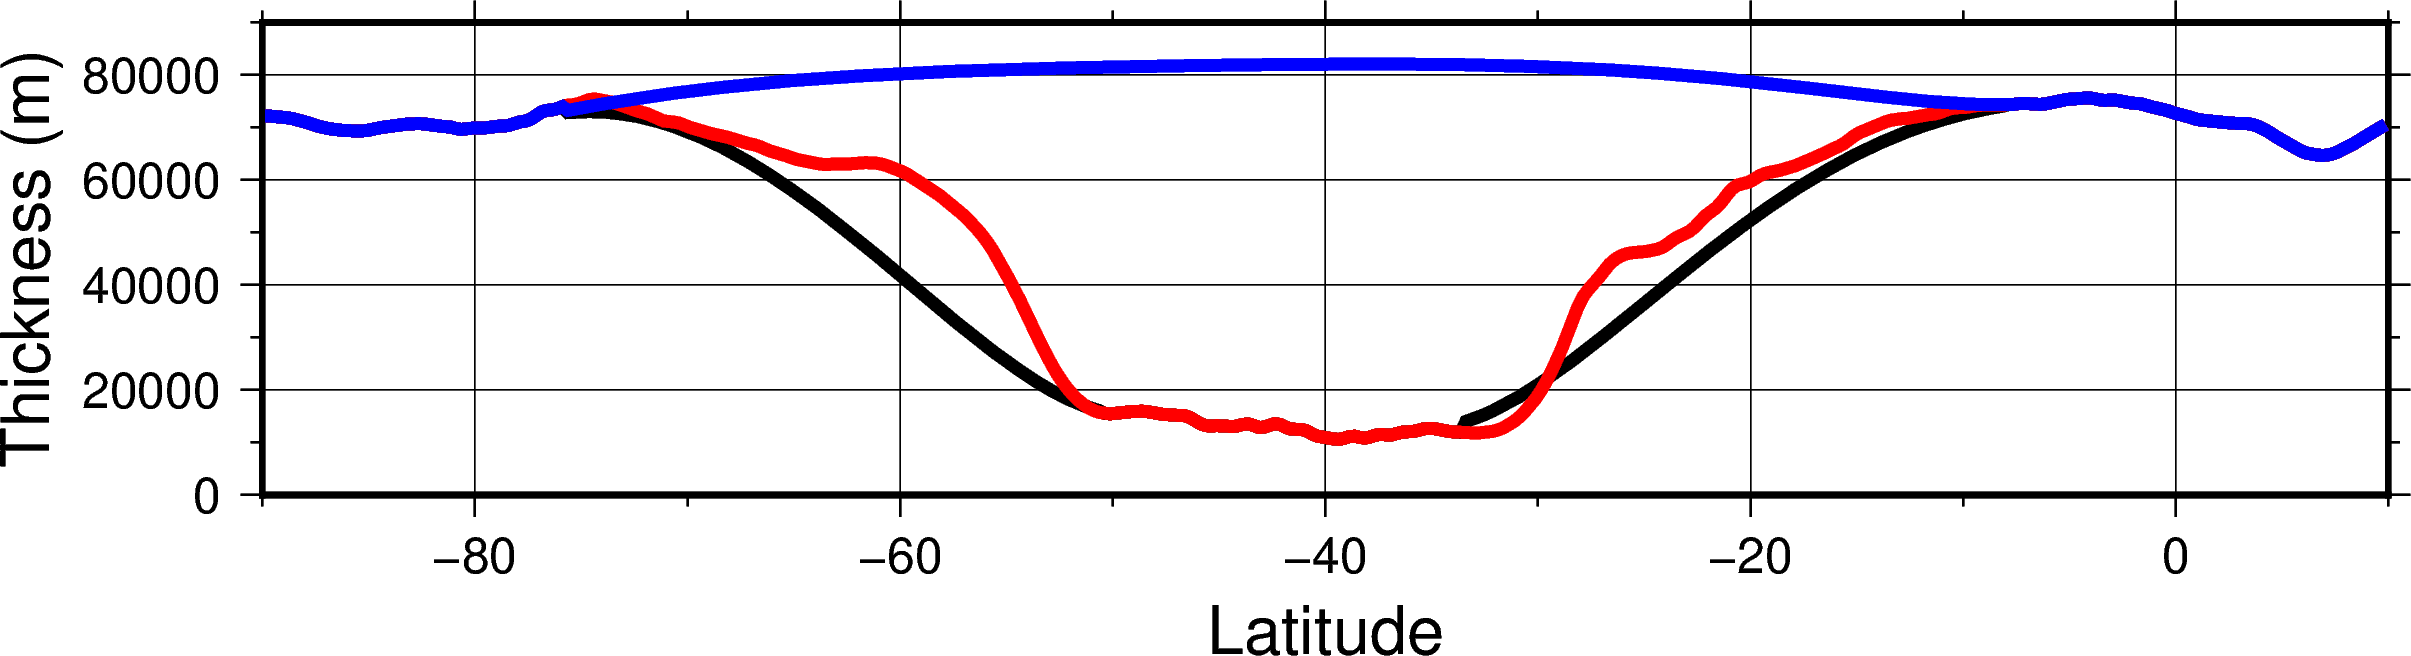

In [14]:
# NB code here assumes we are looking at Hellas
profile_longitude_index = 1000

import pygmt
    
fig = pygmt.Figure()
fig.basemap(region=[-90, 10, 0, 90000], projection="X18c/4c", 
            frame=["WSne", 
                   'xafg+l"Latitude"','yafg+l"Thickness (m)"',])
fig.plot(lats[0:400,profile_longitude_index], sus_ramp[0:400,profile_longitude_index], pen='3p,black')
fig.plot(lats[0:400,profile_longitude_index], sus_orig[0:400,profile_longitude_index], pen='3p,red')
fig.plot(lats[0:400,profile_longitude_index], sus_fill[0:400,profile_longitude_index], pen='3p,blue')
fig.show()

In [16]:
data = np.loadtxt('grids/mincurv/W19_l90_hellas_removed_mincurv.xyz')



ValueError: too many values to unpack (expected 2)

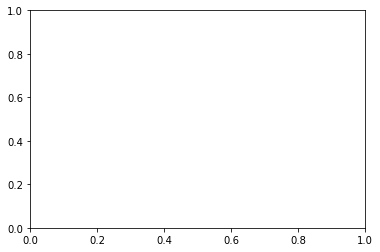

In [19]:
plt.pcolormesh(data[:,2].reshape(720,1440))
